## 基于多目标GP的符号回归

之前都是单目标的回归问题，我们仅关注最优解，但不关注最优解的复杂度。

多目标GP是指使用多个目标函数来评估GP树的适应度。在符号回归问题中，通常使用均方误差（MSE）作为目标函数。然而，MSE并不能很好地反映模型的复杂度，因此，我们还可以使用树的大小作为目标函数。这样，就可以得到更为精简的模型。

In [1]:
import math
import operator
import random
from deap import base, creator, tools, gp, algorithms

# 定义评估函数，包含两个目标：均方误差和树的大小
def evalSymbReg(individual,pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)
    # 计算均方误差（Mean Square Error，MSE）
    mse = ((func(x) - x**2)**2 for x in range(-10, 10))
    # 计算GP树的大小
    size = len(individual)
    return math.fsum(mse), size

# 修改适应度函数，包含两个权重：MSE和树的大小。MSE是最小化，树的大小也是最小化
# 适应度就是根据评估函数的结论得出是否适应
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMulti)

### 遗传算子
遗传算子基本不需要修改。由于是多目标优化问题，所以选择算子需要使用NSGA2（Non-dominated Sorting Genetic Algorithm II）。
NSGA2算法的基本思想是，首先对种群中的个体进行非支配排序，然后根据非支配排序的结果计算拥挤度距离，最后根据非支配排序和拥挤度距离两个指标对个体进行排序。

In [2]:
import random

# 定义函数集合和终端集合
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))
pset.renameArguments(ARG0='x')

# 定义遗传编程操作
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2) # 树高在1-2之间
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, pset=pset)
toolbox.register("select", tools.selNSGA2) # NSGA-II多目标优化算法
toolbox.register("mate", gp.cxOnePoint) # 单点交叉
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset) # 使用均匀变异

/home/glk/project/anaconda3/lib/python3.11/site-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


## 理解：genHalfAndHalf，半全法(half-and-half)

想象我们要构建一个数学表达式，我们有这些构建块：

函数集：
- 加法(+)
- 乘法(*)
终端集：
- 变量x
- 常数1

看看两种方法如何构建深度为2的树：

- FULL方法（全生成法）：
```
第1步: 从根节点开始，必须选择一个函数(因为还没到最大深度)
        +
第2步: 因为深度还是1，两个子节点也必须是函数
        +
      /   \
     *     *
第3步: 现在到达深度2(最大深度)，必须选择终端节点
        +
      /   \
     *     *
    / \   / \
   x   1 x   x
```
最终表达式：(x * 1) + (x * x)

- GROW方法（生长法）：
```
第1步: 从根节点开始，随机选择一个函数
        *
第2步: 可以自由选择函数或终端，比如左边选终端，右边选函数
        *
      /   \
     x     +
第3步: 右边分支继续生长，选择终端
        *
      /   \
     x     +
          / \
         1   x
```
最终表达式：x * (1 + x)

half-and-half的工作方式是：
假设我们要生成4个初始树，half-and-half会：
- 用FULL方法生成2个：
  1. (x * 1) + (x * x)
  2. (x + 1) * (1 + x)
- 用GROW方法生成2个：
  1. x * (1 + x)
  2. x + 1

这就像是让两个不同的"建筑师"来设计树：
- FULL建筑师很规矩，一定要把每个分支都建到最大高度
- GROW建筑师比较随意，可能提前停止某些分支的生长

这种多样性对进化过程很重要，因为：
- 有的问题可能需要完整的复杂表达式（FULL方法提供）
- 有的问题可能需要简单的表达式（GROW方法提供）
- 结合两种方法，我们能得到更丰富的初始种群，增加找到好解的机会

## 理解：tools.selNSGA2，[NSGA-II多目标优化算法](./NSGA-II.md)

## 理解单点交叉与均匀变异

![单点交叉与均匀变异](./img/单点交叉与均匀变异.jpg)

### 算法模块
DEAP算法包提供了eaMuPlusLambda函数，可以比较方便地使用NSGA2的环境选择算子。  
理想情况下，最好还是自行实现演化函数，这样才能完整地使用NSGA-II算法中的锦标赛选择算子。  
NSGA-II算法中的锦标赛选择算子是指，首先从种群中随机选择两个个体，然后根据非支配排序和拥挤度距离两个指标对两个个体进行排序，最后选择排名较高的个体作为父代。简单起见，我们忽略了锦标赛选择算子。

In [3]:
import numpy
from deap import algorithms

# 统计指标
stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(lambda ind: ind.fitness.values[1])
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size) # 将两个统计指标整合在一起
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

population = toolbox.population(n=50)
pop, log  = algorithms.eaMuPlusLambda(
    population=population,
    toolbox=toolbox, 
    mu=len(population), # 父代大小
    lambda_=len(population), # 子代大小
    cxpb=0.9,  # 交叉概率
    mutpb=0.1, # 变异概率
    ngen=10,  # 进化代数
    stats=mstats, 
    halloffame=None,  # 名人堂（保存历史最优解）
    verbose=True
    )
"""
使用(μ+λ)策略：
mu个父代个体产生lambda个子代
从(父代+子代)中选择最优的mu个作为新一代
"""

# 最佳个体
best_ind = tools.selBest(pop, 1)[0] # 最好的一个个体
print('Best individual is:\n', best_ind)
print('\nWith fitness:', best_ind.fitness.values)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min	nevals	std    	avg 	gen	max	min	nevals	std    
0  	50    	42213.5	0  	160004	0  	50    	18887.1	3.78	0  	7  	2  	50    	1.68867
1  	50    	36200.5	1  	42026 	0  	50    	10719.8	2.94	1  	7  	2  	50    	1.33282
2  	50    	33018.2	2  	39346 	0  	50    	14411.5	2.22	2  	5  	2  	50    	0.54   
3  	50    	37762.6	3  	39336 	0  	50    	7708.25	2.04	3  	3  	2  	50    	0.195959
4  	50    	37762.6	4  	39336 	0  	50    	7708.25	2.04	4  	3  	2  	50    	0.195959
5  	50    	37762.6	5  	39336 	0  	50    	7708.25	2.04	5  	3  	2  	50    	0.195959
6  	50    	37762.6	6  	39336 	0  	50    	7708.25	2.04	6  	3  	2  	50    	0.195959
7  	50    	37762.6	7  	39336 	0  	50    	7708.25	2.04	7  	3  	2  	50    	0.195959
8  	50    	37762.6	8  	39336 	0  	50    	7708.25	2.0

基于优化结果，我们还可以绘制Pareto前沿，以便于选择最终的模型。

/tmp/ipykernel_66389/941043822.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=mse, y=sizes, palette="viridis", s=60, edgecolor="w", alpha=0.7)


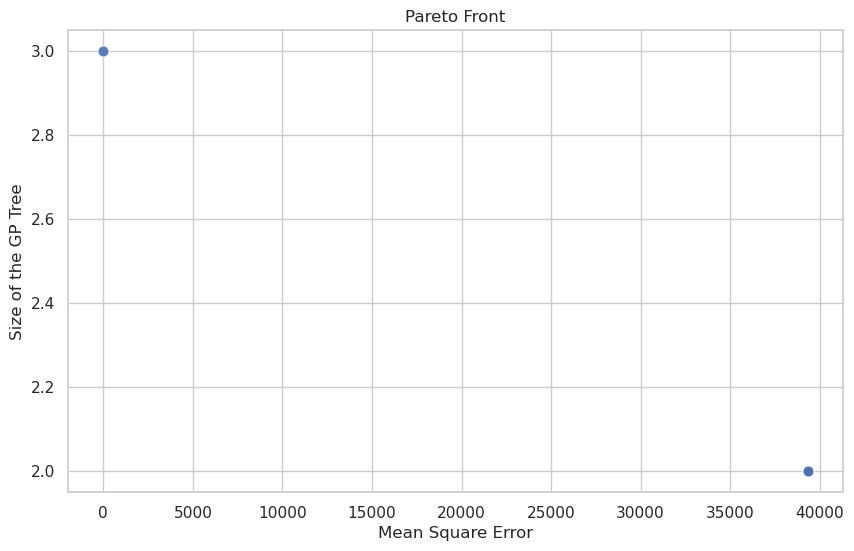

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

# 非支配排序
fronts = tools.sortNondominated(pop, len(pop), first_front_only=True)

# Pareto前沿
pareto_front = fronts[0]
fitnesses = [ind.fitness.values for ind in pareto_front]

# 分离均方误差和树的大小
mse = [fit[0] for fit in fitnesses]
sizes = [fit[1] for fit in fitnesses]

# 使用seaborn绘制散点图
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=mse, y=sizes, palette="viridis", s=60, edgecolor="w", alpha=0.7)
plt.xlabel('Mean Square Error')
plt.ylabel('Size of the GP Tree')
plt.title('Pareto Front')
plt.show()